In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timezone, timedelta

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid",
              context="notebook",
            #   font_scale=1.5
              )

# Diginetica
This notebook preprocesses the diginetica dataset and saves it in a format that can be used by the next notebooks. It also takes care of splitting the data into training, validation and test sets that can be found in 'data/processed datasets/diginetica/'.

To conclude, the notebook contains an exploratory data analysis of the dataset.

## Loading views dataset

In [2]:
diginetica_views = pd.read_csv(r'data\downloaded datasets\diginetica\train-item-views.csv',
                                      sep=';',
                                      usecols=[0, 2, 3, 4])

diginetica_views.columns = ['SessionId', 'ItemId', 'Time', 'Date']

diginetica_views.head()                                      
display(diginetica_views.head())
display(diginetica_views.shape)

,SessionId,ItemId,Time,Date
0,1,81766,526309,2016-05-09
1,1,31331,1031018,2016-05-09
2,1,32118,243569,2016-05-09
3,1,9654,75848,2016-05-09
4,1,32627,1112408,2016-05-09


(1235380, 4)

## Loading purchases dataset

In [3]:
diginetica_purchases = pd.read_csv(r'data\downloaded datasets\diginetica\train-purchases.csv',
                                          sep=';',
                                          usecols=['sessionId', 'itemId', 'timeframe', 'eventdate'])

diginetica_purchases.columns = ['SessionId', 'Time', 'Date', 'ItemId']

display(diginetica_purchases.head())
display(diginetica_purchases.shape)

,SessionId,Time,Date,ItemId
0,150,17100868,2016-05-06,25911
1,151,6454547,2016-05-06,175874
2,156,1721689387,2016-05-27,35324
3,179,343001,2016-05-09,31233
4,246,2311046,2016-05-09,34677


(18025, 4)

Concatenate the views and purchases events into a single dataframe. 

In [4]:
data = pd.concat([diginetica_views, 
                  diginetica_purchases],
                 axis=0,
                 keys=['view', 'purchase'],
                 ).reset_index().rename(columns={'level_0': 'Type'}).drop(columns='level_1')

display(data.head())
display(data.shape)

,Type,SessionId,ItemId,Time,Date
0,view,1,81766,526309,2016-05-09
1,view,1,31331,1031018,2016-05-09
2,view,1,32118,243569,2016-05-09
3,view,1,9654,75848,2016-05-09
4,view,1,32627,1112408,2016-05-09


(1253405, 5)

Perform cleaning and prepare the data that it can be used in session-rec framework.

In [5]:
# code originally from https://github.com/rn5l/session-rec/blob/master/preprocessing/session_based/preprocess_diginetica.py load_data function (type 2)

# replace NaN values in Time column with 0 and convert to int64
data['Time'] = data.Time.fillna(0).astype(np.int64)

# convert time string in Date to timestamp and remove the original column
# start = datetime.strptime('2018-1-1 00:00:00', '%Y-%m-%d %H:%M:%S')
data['Date'] = data.Date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
data['Datestamp'] = data['Date'].apply(lambda x: x.timestamp())
data['Time'] = (data['Time'] / 1000)
data['Time'] = data['Time'] + data['Datestamp']
data['TimeO'] = data.Time.apply(lambda x: datetime.fromtimestamp(x, timezone.utc))


# output
data_start = datetime.fromtimestamp(data.Time.min(), timezone.utc)
data_end = datetime.fromtimestamp(data.Time.max(), timezone.utc)

print('Loaded data set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}\n\tSpan: {} / {}\n\n'.
        format(len(data), data.SessionId.nunique(), data.ItemId.nunique(), data_start.date().isoformat(),
                data_end.date().isoformat()))

data = data.groupby('SessionId').apply(lambda x: x.sort_values('Time'))     # data = data.sort_values(['SessionId'],['Time'])
data.index = data.index.get_level_values(1)

display(data.head())

Loaded data set
	Events: 1253405
	Sessions: 310486
	Items: 123273
	Span: 2016-01-01 / 2016-11-09




C:\Users\Mees\AppData\Local\Temp\ipykernel_13208\4046763853.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('SessionId').apply(lambda x: x.sort_values('Time'))     # data = data.sort_values(['SessionId'],['Time'])


,Type,SessionId,ItemId,Time,Date,Datestamp,TimeO
3,view,1,9654,1.462752e+09,2016-05-09,1.462752e+09,2016-05-09 00:01:15.848000+00:00
5,view,1,33043,1.462752e+09,2016-05-09,1.462752e+09,2016-05-09 00:02:53.912000+00:00
2,view,1,32118,1.462752e+09,2016-05-09,1.462752e+09,2016-05-09 00:04:03.569000+00:00
6,view,1,12352,1.462752e+09,2016-05-09,1.462752e+09,2016-05-09 00:05:29.870000+00:00
7,view,1,35077,1.462752e+09,2016-05-09,1.462752e+09,2016-05-09 00:06:30.072000+00:00


Filter data on minimum item support of 5 and session length of 2. Meaning that we only keep sessions with at least 2 items and items that have been viewed at least 5 times.

In [6]:
# code originally from https://github.com/rn5l/session-rec/blob/master/preprocessing/session_based/preprocess_diginetica.py filter data function

def filter_min_date(data, min_date='2016-05-07'):
    
    print('filter_min_date')
    
    min_datetime = datetime.strptime(min_date + ' 00:00:00', '%Y-%m-%d %H:%M:%S')

    # filter
    session_max_times = data.groupby('SessionId').Time.max()
    session_keep = session_max_times[session_max_times > min_datetime.timestamp()].index

    data = data[np.in1d(data.SessionId, session_keep)]

    # output
    data_start = datetime.fromtimestamp(data.Time.min(), timezone.utc)
    data_end = datetime.fromtimestamp(data.Time.max(), timezone.utc)

    print('Filtered data set min date \n\tEvents: {}\n\tSessions: {}\n\tItems: {}\n\tSpan: {} / {}\n\n'.
          format(len(data), data.SessionId.nunique(), data.ItemId.nunique(), data_start.date().isoformat(),
                 data_end.date().isoformat()))

    return data

data = filter_min_date(data)

display(data.head())

filter_min_date
Filtered data set min date 
	Events: 325993
	Sessions: 81057
	Items: 63250
	Span: 2016-01-08 / 2016-11-09




,Type,SessionId,ItemId,Time,Date,Datestamp,TimeO
3,view,1,9654,1.462752e+09,2016-05-09,1.462752e+09,2016-05-09 00:01:15.848000+00:00
5,view,1,33043,1.462752e+09,2016-05-09,1.462752e+09,2016-05-09 00:02:53.912000+00:00
2,view,1,32118,1.462752e+09,2016-05-09,1.462752e+09,2016-05-09 00:04:03.569000+00:00
6,view,1,12352,1.462752e+09,2016-05-09,1.462752e+09,2016-05-09 00:05:29.870000+00:00
7,view,1,35077,1.462752e+09,2016-05-09,1.462752e+09,2016-05-09 00:06:30.072000+00:00


In [7]:
def filter_data(data, min_item_support=5, min_session_length=2):
    # filter session length
    session_lengths = data.groupby('SessionId').size()
    session_lengths = session_lengths[ session_lengths >= min_session_length ]
    data = data[np.in1d(data.SessionId, session_lengths.index)]

    # filter item support
    data['ItemSupport'] = data.groupby('ItemId')['ItemId'].transform('count')
    data = data[data.ItemSupport >= min_item_support]

    # filter session length again, after filtering items
    session_lengths = data.groupby('SessionId').size()
    data = data[np.in1d(data.SessionId, session_lengths[session_lengths >= min_session_length].index)]
    
    # output
    data_start = datetime.fromtimestamp(data.Time.min(), timezone.utc)
    data_end = datetime.fromtimestamp(data.Time.max(), timezone.utc)

    print('Filtered data set default \n\tEvents: {}\n\tSessions: {}\n\tItems: {}\n\tSpan: {} / {}\n\n'.
          format(len(data), data.SessionId.nunique(), data.ItemId.nunique(), data_start.date().isoformat(),
                 data_end.date().isoformat()))

    return data

data = filter_data(data)

data.head()

Filtered data set default 
	Events: 216241
	Sessions: 47846
	Items: 15120
	Span: 2016-01-08 / 2016-10-22




C:\Users\Mees\AppData\Local\Temp\ipykernel_13208\1670490224.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ItemSupport'] = data.groupby('ItemId')['ItemId'].transform('count')


,Type,SessionId,ItemId,Time,Date,Datestamp,TimeO,ItemSupport
3,view,1,9654,1.462752e+09,2016-05-09,1.462752e+09,2016-05-09 00:01:15.848000+00:00,74
5,view,1,33043,1.462752e+09,2016-05-09,1.462752e+09,2016-05-09 00:02:53.912000+00:00,41
2,view,1,32118,1.462752e+09,2016-05-09,1.462752e+09,2016-05-09 00:04:03.569000+00:00,19
6,view,1,12352,1.462752e+09,2016-05-09,1.462752e+09,2016-05-09 00:05:29.870000+00:00,79
7,view,1,35077,1.462752e+09,2016-05-09,1.462752e+09,2016-05-09 00:06:30.072000+00:00,47


Here, we split the data. We will take 7 days test data, and the remaining data will be used for training. This approach is based on gru4rec paper which is often used as a benchmark for session-based recommendation.

The function below creates an *incorrect* traint test split where only two sessions end up in the test set. This is not a good split, but it is used to demonstrate the data preparation process. In the next steps, we will create a correct train-test split. First running the instructions that are explained [here](https://github.com/rn5l/session-rec/tree/5dcd583cbd8d44703a5248b9a308945f24b91390?tab=readme-ov-file#--------dataset-preprocessing--------) and store them in 'data/premade datasets/diginetica. The default values are used for the preprocessing parameters which were also mentioned above. Unfortunately, the preprocessing of this repo does not take into account the event column. Therefore, we will add it manually. We will extract the session ids from the correctly generated train, test, validation splits and use them to filter the concatenated dataframe to create the final train, test, and validation dataframes with an event column.

In [8]:
# def split_data(data, output_file, days_test=7):
#     # Ensure 'Time' column is in datetime format
#     data['Time'] = pd.to_datetime(data['Time'], unit='s')
    
#     # Determine the end of the dataset
#     data_end = data['Time'].max()
#     print(f'Data end: {data_end}')
#     test_from = data_end - timedelta(days=days_test)
#     print(f'Test from: {test_from}')

#     # Identify sessions for training and testing
#     session_max_times = data.groupby('SessionId')['Time'].max()
#     session_train = session_max_times[session_max_times <= test_from].index
#     session_test = session_max_times[session_max_times > test_from].index
    
#     print(f'Train set {session_train}')
#     print(f'test set {session_test}')
    
#     # Split the data into train and test sets
#     train = data[data['SessionId'].isin(session_train)]
#     trlength = train.groupby('SessionId').size()
#     train = train[train['SessionId'].isin(trlength[trlength >= 2].index)]
    
#     test = data[data['SessionId'].isin(session_test)]
#     test = test[test['ItemId'].isin(train['ItemId'])]
#     tslength = test.groupby('SessionId').size()
#     test = test[test['SessionId'].isin(tslength[tslength >= 2].index)]
    
#     print(f'Full train set\n\tEvents: {len(train)}\n\tSessions: {train["SessionId"].nunique()}\n\tItems: {train["ItemId"].nunique()}')
#     train.to_csv(f'{output_file}_train_full.txt', sep='\t', index=False)
    
#     print(f'Test set\n\tEvents: {len(test)}\n\tSessions: {test["SessionId"].nunique()}\n\tItems: {test["ItemId"].nunique()}')
#     test.to_csv(f'{output_file}_test.txt', sep='\t', index=False)

#     # Determine the end of the training set
#     data_end = train['Time'].max()
#     valid_from = data_end - timedelta(days=days_test)
    
#     # Identify sessions for training and validation within the training set
#     session_max_times = train.groupby('SessionId')['Time'].max()
#     session_train = session_max_times[session_max_times < valid_from].index
#     session_valid = session_max_times[session_max_times >= valid_from].index
    
#     train_tr = train[train['SessionId'].isin(session_train)]
#     valid = train[train['SessionId'].isin(session_valid)]
#     valid = valid[valid['ItemId'].isin(train_tr['ItemId'])]
#     tslength = valid.groupby('SessionId').size()
#     valid = valid[valid['SessionId'].isin(tslength[tslength >= 2].index)]
    
#     print(f'Train set\n\tEvents: {len(train_tr)}\n\tSessions: {train_tr["SessionId"].nunique()}\n\tItems: {train_tr["ItemId"].nunique()}')
#     train_tr.to_csv(f'{output_file}_train_tr.txt', sep='\t', index=False)
    
#     print(f'Validation set\n\tEvents: {len(valid)}\n\tSessions: {valid["SessionId"].nunique()}\n\tItems: {valid["ItemId"].nunique()}')
#     valid.to_csv(f'{output_file}_train_valid.txt', sep='\t', index=False)


# path_proc = 'data\processed datasets\diginetica\interactions'

# split_data(data, output_file=path_proc)

In [9]:
test_ids = pd.read_csv(r'data\premade datasets\diginetica\train-item-views_test.txt',
                           sep='\t',
                           usecols=['SessionId'])['SessionId'].unique()
print(f'Test ids: {test_ids}')

validation_ids = pd.read_csv(r'data\premade datasets\diginetica\train-item-views_train_valid.txt',
                           sep='\t',
                           usecols=['SessionId'])['SessionId'].unique()

train_ids = pd.read_csv(r'data\premade datasets\diginetica\train-item-views_train_tr.txt',
                           sep='\t',
                           usecols=['SessionId'])['SessionId'].unique()

# use the ids to split the data into train, validation and test sets and save them to files
data[data['SessionId'].isin(test_ids)].to_csv(r'data\processed datasets\diginetica\interactions_test.txt', sep='\t', index=False)
data[data['SessionId'].isin(validation_ids)].to_csv(r'data\processed datasets\diginetica\interactions_train_valid.txt', sep='\t', index=False)
data[data['SessionId'].isin(train_ids)].to_csv(r'data\processed datasets\diginetica\interactions_train_tr.txt', sep='\t', index=False)

Test ids: [   289    290    302 ... 600404 600608 600674]


In [10]:
test_ids = pd.read_csv(r'data\premade datasets\diginetica\train-item-views_test.txt',
                           sep='\t',
                           usecols=['SessionId'])['SessionId'].unique()
print(f'Test ids: {test_ids}')

validation_ids = pd.read_csv(r'data\premade datasets\diginetica\train-item-views_train_valid.txt',
                           sep='\t',
                           usecols=['SessionId'])['SessionId'].unique()

train_ids = pd.read_csv(r'data\premade datasets\diginetica\train-item-views_train_tr.txt',
                           sep='\t',
                           usecols=['SessionId'])['SessionId'].unique()

# use the ids to split the data into train, validation and test sets and save them to files
test = data[data['SessionId'].isin(test_ids)]
test.to_csv(r'data\processed datasets\diginetica\interactions_test.txt', sep='\t', index=False)
validation = data[data['SessionId'].isin(validation_ids)]
validation.to_csv(r'data\processed datasets\diginetica\interactions_train_valid.txt', sep='\t', index=False)
train = data[data['SessionId'].isin(train_ids)]
train.to_csv(r'data\processed datasets\diginetica\interactions_train_tr.txt', sep='\t', index=False)

display('Test set:')
display(test.head())
display(test.shape)
display('Validation set:')
display(validation.head())
display(validation.shape)
display('Train set:')
display(train.head())
display(train.shape)

Test ids: [   289    290    302 ... 600404 600608 600674]


'Test set:'

,Type,SessionId,ItemId,Time,Date,Datestamp,TimeO,ItemSupport
1044,view,289,125013,1.464221e+09,2016-05-26,1.464221e+09,2016-05-26 00:00:18.301000+00:00,7
1045,view,289,64068,1.464222e+09,2016-05-26,1.464221e+09,2016-05-26 00:14:07.735000+00:00,6
1046,view,289,133346,1.464222e+09,2016-05-26,1.464221e+09,2016-05-26 00:14:38.934000+00:00,6
1050,view,289,198930,1.464222e+09,2016-05-26,1.464221e+09,2016-05-26 00:18:48.607000+00:00,7
1066,view,302,36202,1.464221e+09,2016-05-26,1.464221e+09,2016-05-26 00:00:45.583000+00:00,23


(64761, 8)

'Validation set:'

,Type,SessionId,ItemId,Time,Date,Datestamp,TimeO,ItemSupport
742,view,199,234568,1.464134e+09,2016-05-25,1.464134e+09,2016-05-25 00:00:09.275000+00:00,130
741,view,199,85571,1.464134e+09,2016-05-25,1.464134e+09,2016-05-25 00:00:45.383000+00:00,119
743,view,200,16486,1.464135e+09,2016-05-25,1.464134e+09,2016-05-25 00:01:48.048000+00:00,56
744,view,200,16486,1.464135e+09,2016-05-25,1.464134e+09,2016-05-25 00:02:22.826000+00:00,56
757,view,203,36271,1.464134e+09,2016-05-25,1.464134e+09,2016-05-25 00:00:37.001000+00:00,64


(47875, 8)

'Train set:'

,Type,SessionId,ItemId,Time,Date,Datestamp,TimeO,ItemSupport
3,view,1,9654,1.462752e+09,2016-05-09,1.462752e+09,2016-05-09 00:01:15.848000+00:00,74
5,view,1,33043,1.462752e+09,2016-05-09,1.462752e+09,2016-05-09 00:02:53.912000+00:00,41
2,view,1,32118,1.462752e+09,2016-05-09,1.462752e+09,2016-05-09 00:04:03.569000+00:00,19
6,view,1,12352,1.462752e+09,2016-05-09,1.462752e+09,2016-05-09 00:05:29.870000+00:00,79
7,view,1,35077,1.462752e+09,2016-05-09,1.462752e+09,2016-05-09 00:06:30.072000+00:00,47


(102272, 8)

# Exploratory Data Analysis

In [16]:
# store the data in a pickle file
data.to_pickle('data\processed datasets\diginetica\data.pkl')

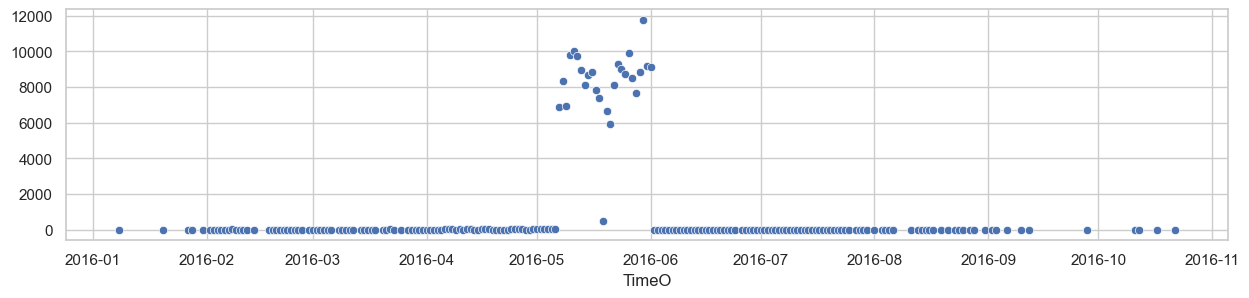

In [38]:
# how many events are there per day?
events_per_day = data.groupby(data.TimeO.dt.date).size()

sns.scatterplot(data=events_per_day)
# change size of plot
plt.gcf().set_size_inches(15, 3)

As can be seen in the plot above, most interactions occur in may and june 2016. This large difference in number of interactions per day won't be a problem for the model, as the model will be trained on the entire dataset. However, it is important to keep in mind that the model will be trained on data from a specific period, which might not be representative for the entire dataset.

How many cold start sessions are there in the dataset?  
Lets create a histogram with the frequency of the length of the sessions.

Text(5.019520963089914, 12000, 'Mean = 4.52')

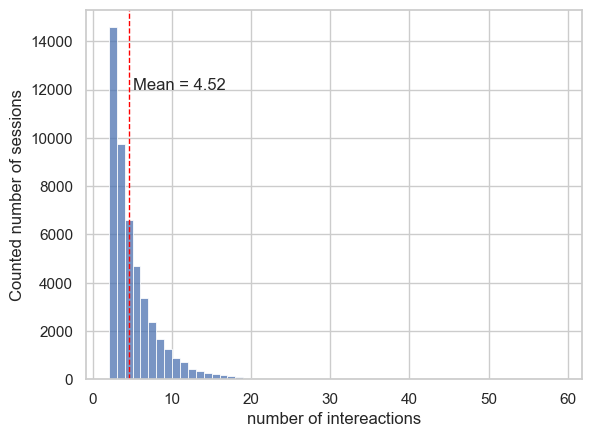

In [11]:
data_per_session = data.groupby('SessionId').size().reset_index(name='number of intereactions')

sns.histplot(data_per_session['number of intereactions'], binwidth=1)
plt.ylabel('Counted number of sessions')

# add a line for the mean
plt.axvline(data_per_session['number of intereactions'].mean(), color='red', linestyle='dashed', linewidth=1)
# print the mean
plt.text(data_per_session['number of intereactions'].mean() + 0.5, 12000, 'Mean = {:.2f}'.format(data_per_session['number of intereactions'].mean()))

On average, 4.52 interactions are made per session. This is a relatively low number of interactions per session and indicates that the dataset is sparse and that the dataset contains many cold user start sessions.  

How are the interactions distributed over the items? Does one item dominate the dataset? or are the interactions spread out over the items?

'top 10 most popular items:'

,ItemId,number of intereactions
6869,42271,308
13548,375888,302
14064,379023,279
6513,36956,266
6240,36031,263
12094,164627,262
11969,161039,260
8047,58581,254
12509,176018,252
4434,22894,251


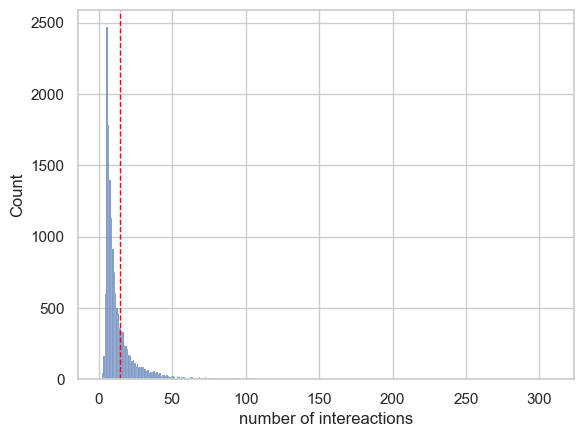

In [13]:
data_per_item = data.groupby('ItemId').size().reset_index(name='number of intereactions').sort_values('number of intereactions', ascending=False)
sns.histplot(data_per_item['number of intereactions'], binwidth=1)

# add a line for the mean
plt.axvline(data_per_item['number of intereactions'].mean(), color='red', linestyle='dashed', linewidth=1)

display('top 10 most popular items:')
display(data_per_item.head(10))

In the above histogram and top 10 table, we can see that some items are very popular and have been interacted with many times, while most items have been interacted with only a few times. This is a typical characteristic of e-commerce datasets. And the cold item start is visible in the histogram.

Do items get to be interacted with more as time goes on? And how are the interactions distributed over time?

In [14]:
# create a dataframe where we track the first and last time an item was interacted with by taking the min and max of the Time column for each item. also count the number of interactions per item
data_per_item = data.groupby('ItemId').agg({'TimeO': ['min', 'max', 'count']}).reset_index()

# compute the time between the first and last interaction for each item
data_per_item['time between first and last interaction'] = data_per_item['TimeO']['max'] - data_per_item['TimeO']['min']
data_per_item


ItemId                            TimeO  \
                                           min   
0           2 2016-05-08 00:05:25.902000+00:00   
1           3 2016-05-07 00:18:53.958000+00:00   
2           6 2016-05-15 00:12:26.256000+00:00   
3           7 2016-05-11 00:04:09.608000+00:00   
4           9 2016-05-07 00:04:50.490000+00:00   
...       ...                              ...   
15115  506446 2016-05-30 00:07:54.082000+00:00   
15116  512539 2016-05-21 00:08:08.736000+00:00   
15117  539560 2016-05-23 00:11:31.996000+00:00   
15118  568637 2016-05-12 00:04:14.624000+00:00   
15119  707327 2016-05-24 00:03:44.003000+00:00   

                                              \
                                   max count   
0     2016-05-31 00:08:58.230000+00:00    14   
1     2016-05-16 00:16:38.776000+00:00     9   
2     2016-06-01 00:00:09.009000+00:00     6   
3     2016-06-01 00:03:15.360000+00:00    20   
4     2016-05-28 00:15:55.803000+00:00    13   
...                                ...   ...   
15115 2016-05-30 00:18:03.248000+00:00     7   
15116 2016-05-31 00:02:30.799000+00:00     8   
15117 2016-05-28 00:03:32.418000+00:00     6   
15118 2016-06-01 00:14:14.369000+00:00    16   
15119 2016-05-30 00:02:29.435000+00:00     5   

      time between first and last interaction  
                                               
0                     23 days 00:03:32.328000  
1                      8 days 23:57:44.818000  
2                     16 days 23:47:42.753000  
3                     20 days 23:59:05.752000  
4                     21 days 00:11:05.313000  
...                                       ...  
15115                  0 days 00:10:09.166000  
15116                  9 days 23:54:22.063000  
15117                  4 days 23:52:00.422000  
15118                 20 days 00:09:59.745000  
15119                  5 days 23:58:45.432000  

[15120 rows x 5 columns]

<Axes: xlabel='time between first and last interaction', ylabel='Count'>

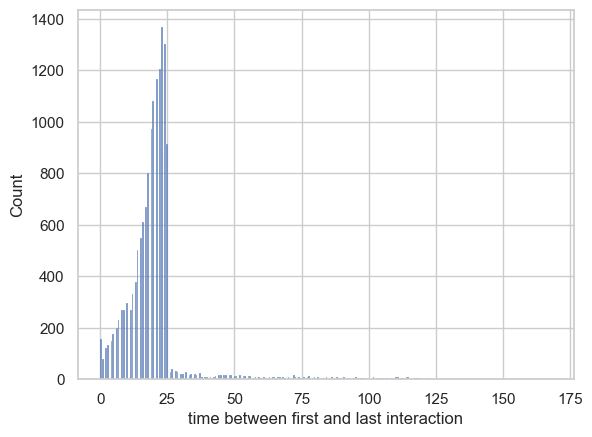

In [31]:
# create a boxplot of the distribution of the time between the first and last interaction for each item
sns.histplot(x=data_per_item['time between first and last interaction'].dt.days) 

The above histogram shows that most of the products are interected with up to 25 days. Only a few products are interacted with for more than 25 days. This makes sense as most interactions are made in may and june 2016. Lets add the month column to the dataset and see how the interactions are distributed over the months.

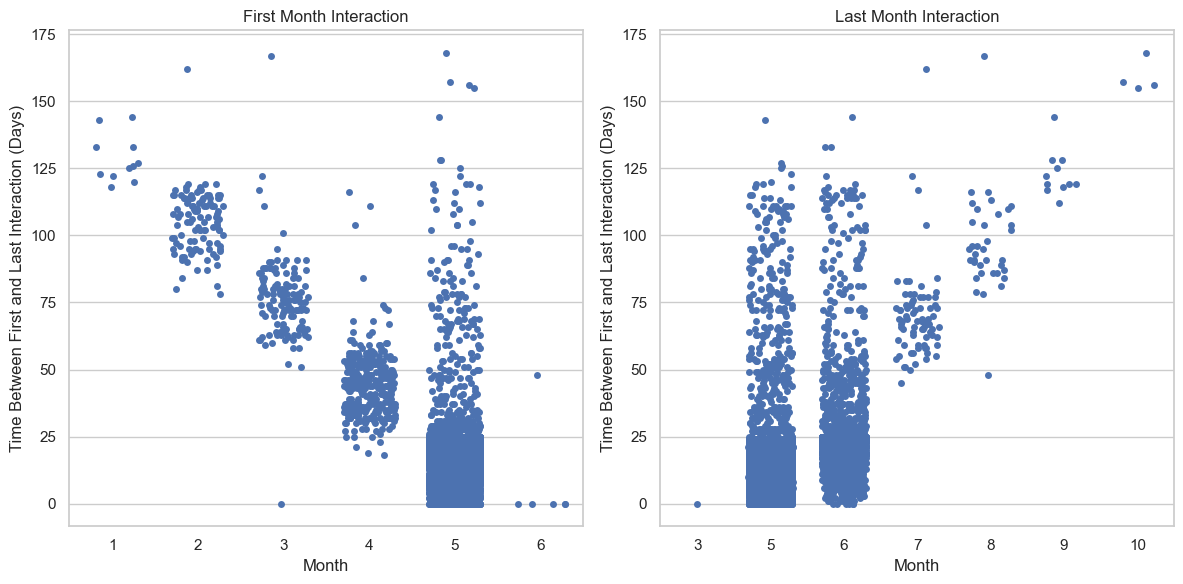

In [54]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first strip plot on the first subplot
sns.stripplot(x=data_per_item['First month interaction'], 
              y=data_per_item['time between first and last interaction'].dt.days,
              jitter=0.3,
              ax=axes[0])

# Set the title and labels for the first subplot
axes[0].set_title('First Month Interaction')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Time Between First and Last Interaction (Days)')

# Plot the second strip plot on the second subplot
sns.stripplot(x=data_per_item['Last month interaction'], 
              y=data_per_item['time between first and last interaction'].dt.days,
              jitter=0.3,
              ax=axes[1])

# Set the title and labels for the second subplot
axes[1].set_title('Last Month Interaction')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Time Between First and Last Interaction (Days)')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


May and June are the most popular months for interactions, or at least the months with the most interactions in the dataset. The dataset is not balanced over months and this might be a problem for the model. The model will be trained on data from a specific period, which might not be representative for the entire dataset. This is something to keep in mind when interpreting the results of the model.